In [2]:
import utils
import plotting
import postprocessing
import numpy as np
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
from hh_vars import samples, sig_key, qcd_key, data_key
import os
from utils import CUT_MAX_VAL

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfFileMerger

from copy import deepcopy

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = "../../../"
samples_dir = f"{MAIN_DIR}/../data/skimmer/Jan31"
signal_samples_dir = f"{MAIN_DIR}/../data/skimmer/Feb3"
year = "2017"

plot_dir = "../../../plots/PostProcessing/Feb15"
templates_dir = "templates/Jan31/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {templates_dir}")

In [5]:
# Both Jet's Msds > 50 & at least one jet with Txbb > 0.8
filters = [
    [
        ("('ak8FatJetMsd', '0')", ">=", 50),
        ("('ak8FatJetMsd', '1')", ">=", 50),
        ("('ak8FatJetParticleNetMD_Txbb', '0')", ">=", 0.8),
    ],
    [
        ("('ak8FatJetMsd', '0')", ">=", 50),
        ("('ak8FatJetMsd', '1')", ">=", 50),
        ("('ak8FatJetParticleNetMD_Txbb', '1')", ">=", 0.8),
    ],
]

# {label: {cutvar: [min, max], ...}, ...}
selection_regions = {
    "passCat1": {
        "BDTScore": [0.986, CUT_MAX_VAL],
        "bbFatJetParticleNetMD_Txbb": [0.976, CUT_MAX_VAL],
    },
    "BDTOnly": {
        "BDTScore": [0.986, CUT_MAX_VAL],
    },
    "fail": {
        "bbFatJetParticleNetMD_Txbb": [0.8, 0.976],
    },
}

# bb msd is final shape var
shape_var = ("bbFatJetMsd", r"$m^{bb}$ (GeV)")
shape_bins = [20, 50, 250]  # num bins, min, max
blind_window = [100, 150]

Load samples

In [6]:
cutflow = pd.DataFrame(index=list(samples.keys()))
events_dict = utils.load_samples(signal_samples_dir, {sig_key: samples[sig_key]}, year, filters)
events_dict |= utils.load_samples(samples_dir, {k: samples[k] for k in samples.keys() - [sig_key]}, year, filters)
utils.add_to_cutflow(events_dict, "BDTPreselection", "weight", cutflow)

# print weighted sample yields
for sample in events_dict:
    tot_weight = np.sum(events_dict[sample]["weight"].values)
    print(f"Pre-selection {sample} yield: {tot_weight:.2f}")

Pre-selection HHbbVV yield: 3.93
Pre-selection W+Jets yield: 22355.24
Pre-selection QCD yield: 3225080.38
Pre-selection Data yield: 869653.00
Pre-selection TT yield: 219865.36


Scale factors, bb VV assignment, derive variables

In [7]:
postprocessing.apply_weights(events_dict, year, cutflow)
bb_masks = postprocessing.bb_VV_assignment(events_dict)
postprocessing.derive_variables(events_dict, bb_masks)

QCD_SCALE_FACTOR = 0.7724483539828693


Lund plane SFs

In [8]:
events = events_dict[sig_key]
events = postprocessing.postprocess_lpsfs(events)
events["finalWeight_preLP"] = events["finalWeight"]
events["finalWeight"] = events["finalWeight"] * events["VV_lp_sf_nom"][0]
events_dict[sig_key] = events

In [9]:
postprocessing.load_bdt_preds(events_dict, f"{samples_dir}/{year}/preds.npy", list(samples.keys()))

sig_scale = 498658.57479645597


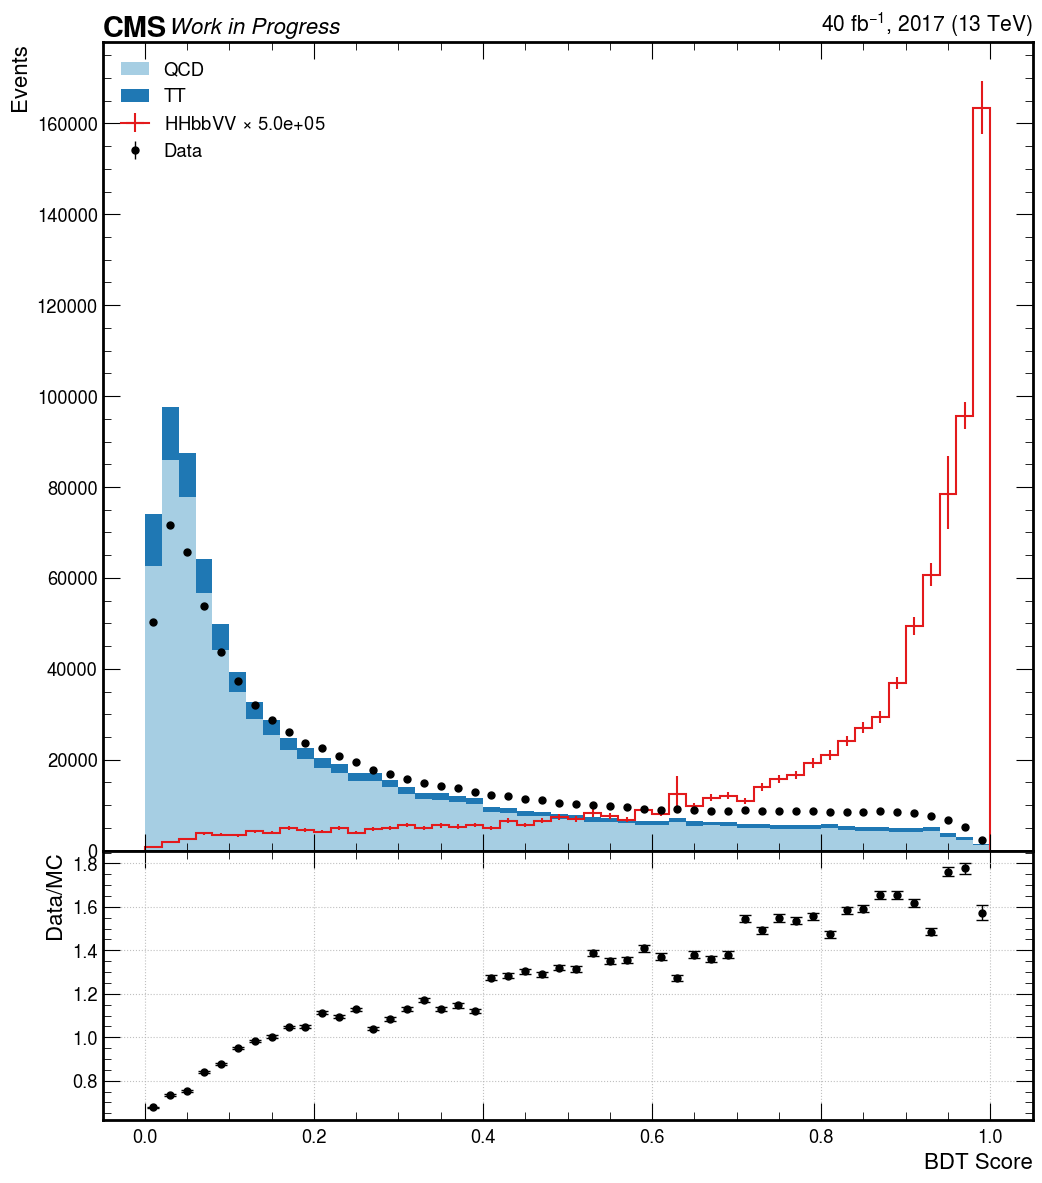

In [10]:
# {var: (bins, label)}
control_plot_vars = {
    "BDTScore": ([50, 0, 1], r"BDT Score"),
}

postprocessing.control_plots(events_dict, bb_masks, control_plot_vars, plot_dir)

Overall BDT SF

In [15]:
sel, cf = utils.make_selection(selection_regions["BDTOnly"], events_dict, bb_masks, prev_cutflow=cutflow)
lp_sf, unc, uncs = postprocessing.get_lpsf(events_dict[sig_key], sel[sig_key])
print(f"LP SF: {lp_sf:.2f} ± {unc:.2f}")
print("Uncs: ", uncs)
# events_dict[sig_key]["finalWeight"] = events_dict[sig_key]["finalWeight_preLP"] * lp_sf

LP SF: 0.82 ± 0.16
Uncs:  {'syst_unc': 0.1569771137764572, 'stat_unc': 0.04281860530921007, 'sj_pt_unc': 0.0029540860525555874, 'sj_matching_unc': 0.10646219215378903}


In [12]:
del events_dict["W+Jets"]

In [13]:
templates = postprocessing.get_templates(
    events_dict,
    bb_masks,
    selection_regions,
    shape_var,
    shape_bins,
    blind_window,
    plot_dir=plot_dir,
    prev_cutflow=cutflow,
)
postprocessing.save_templates(templates, blind_window, f"{templates_dir}/templates.pkl")

Pass region signal yield: 0.13601586160722562
background yield from data in sidebands: 68.0


Mass Shape SFs

In [14]:
label = "BDTOnly"
region = selection_regions[label]
weight_key = "finalWeight"
sel, cf = utils.make_selection(region, events_dict, bb_masks, prev_cutflow=cutflow)

template = utils.singleVarHist(
    events_dict,
    shape_var[0],
    shape_bins,
    shape_var[1],
    bb_masks,
    weight_key=weight_key,
    selection=sel,
    blind_region=blind_window,
)

In [ ]:
events = events_dict[sig_key][sel[sig_key]]

toy_hists = []
for i in range(events["VV_lp_sf_toys"].shape[1]):
    toy_hists.append(
        np.histogram(
            utils.get_feat(events, shape_var[0], bb_masks[sig_key][sel[sig_key]]),
            np.linspace(*shape_bins[1:], shape_bins[0] + 1),
            weights=events["finalWeight_preLP"] * events["VV_lp_sf_toys"][i].values,
        )[0]
    )

sys_up_down = []
for key in ["VV_lp_sf_sys_up", "VV_lp_sf_sys_down"]:
    sys_up_down.append(
        np.histogram(
            utils.get_feat(events, shape_var[0], bb_masks[sig_key][sel[sig_key]]),
            np.linspace(*shape_bins[1:], shape_bins[0] + 1),
            weights=events["finalWeight_preLP"] * events[key][0].values,
        )[0]
    )

nom_vals = template["HHbbVV", :].values()

uncs = {
    "stat_unc": np.minimum(nom_vals, np.std(toy_hists[1:], axis=0)) / nom_vals,  # cap at 100% unc
    "syst_rat_unc": np.minimum(nom_vals, (np.abs(sys_up_down[0] - sys_up_down[1])) / 2) / nom_vals,
}

tot_matched = np.sum(np.sum(events[f"ak8FatJetHVV"].astype(bool)))

# fraction of subjets > 350 * 0.21 measured by CASE
uncs["sj_pt_unc"] = (np.sum(events[f"VV_lp_sf_num_sjpt_gt350"][0]) / tot_matched) * 0.21

num_prongs = events["ak8FatJetHVVNumProngs"][0]

sj_matching_unc = np.sum(events[f"VV_lp_sf_double_matched_event"][0])
for nump in range(2, 5):
    sj_matching_unc += (
        np.sum(events[f"VV_lp_sf_unmatched_quarks"][0][num_prongs == nump]) / nump
    )

uncs["sj_matching_unc"] = sj_matching_unc / tot_matched

In [ ]:
tot_uncs = np.linalg.norm([val for val in uncs.values()], axis=0)

In [ ]:
print(uncs)
print(tot_uncs)

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(np.arange(1, 21), tot_uncs)
plt.ylim([0, 1.2])
plt.xlabel("Mass Bin")
plt.ylabel("Relative Uncertainty")
plt.title("Uncertainties from BDT Cut")
plt.savefig(f"{plot_dir}/rel_uncs.pdf")

In [ ]:
templates = postprocessing.get_templates(
    events_dict,
    bb_masks,
    selection_regions,
    shape_var,
    shape_bins,
    blind_window,
    sig_err=tot_uncs,
    plot_dir=plot_dir,
    prev_cutflow=cutflow,
    show=True,
)

In [ ]:
tot_rel_unc = np.linalg.norm([val for val in uncs.values()])